Import libraries

In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import psycopg2.extras
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Get the sources:
- demand
- costs
- mlor

In [30]:
consegne = pd.read_csv('../data/antal_consegne23_24.xlsx - Dettaglio ordini e consegne.csv')
df = consegne[['so_date', 'item_id', 'so_quantity', 'actual_lt']]
df = df.rename(columns={'so_quantity':'quantity', 'actual_lt':'lt'})
df = df.drop(df[df.so_date == ' '].index)
df = df.drop(df[(df.so_date < '2023-01-01') & (df.so_date > '2025-03-01')].index) # limit to 2023 till 2025-02 incl.
df.so_date = pd.to_datetime(df.so_date)
df['lt'] = df['lt'].astype(str).astype(int)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29910 entries, 0 to 32533
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   so_date   29910 non-null  datetime64[ns]
 1   item_id   29910 non-null  object        
 2   quantity  29910 non-null  int64         
 3   lt        29910 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.1+ MB


In [10]:
# cost
cost = pd.read_csv('../data/antal_article_value.csv', decimal='.', thousands=',')
cost = cost[['category', 'item_id', 'unit_value']]
cost = cost.rename(columns={'unit_value':'unit_cost'})
cost['unit_cost'] = cost['unit_cost'].astype(str).astype(float)
cost = cost.drop_duplicates('item_id', keep='first') # keep only recent values
cost.head()
cost.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1977 entries, 0 to 3994
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   category   1977 non-null   object 
 1   item_id    1977 non-null   object 
 2   unit_cost  1976 non-null   float64
dtypes: float64(1), object(2)
memory usage: 61.8+ KB


In [ ]:
sale_vol.sort_values()

,so_date,item_id,quantity,lt,category,unit_cost,line_cost
0,2024-04-24,00517,2,35,Rinvii (95),24.68,49.36
1,2024-04-24,00818Z,3,35,Rinvii (95),98.25,294.75
2,2024-04-24,04919F,2,35,Pulegge (90),24.49,48.98
3,2024-04-24,10021A,2,35,Pulegge (90),45.87,91.74
4,2024-04-24,501.110,8,35,Stopper (120),48.53,388.24
...,...,...,...,...,...,...,...
29905,2023-06-05,HS22.40S,5,12,Full Batten (50),21.28,106.40
29906,2023-08-29,R07.05,10,4,Soft Link (110),5.49,54.90
29907,2023-08-29,R10.07,10,4,Soft Link (110),6.53,65.30
29908,2023-08-29,R14.10,10,4,Soft Link (110),7.66,76.60


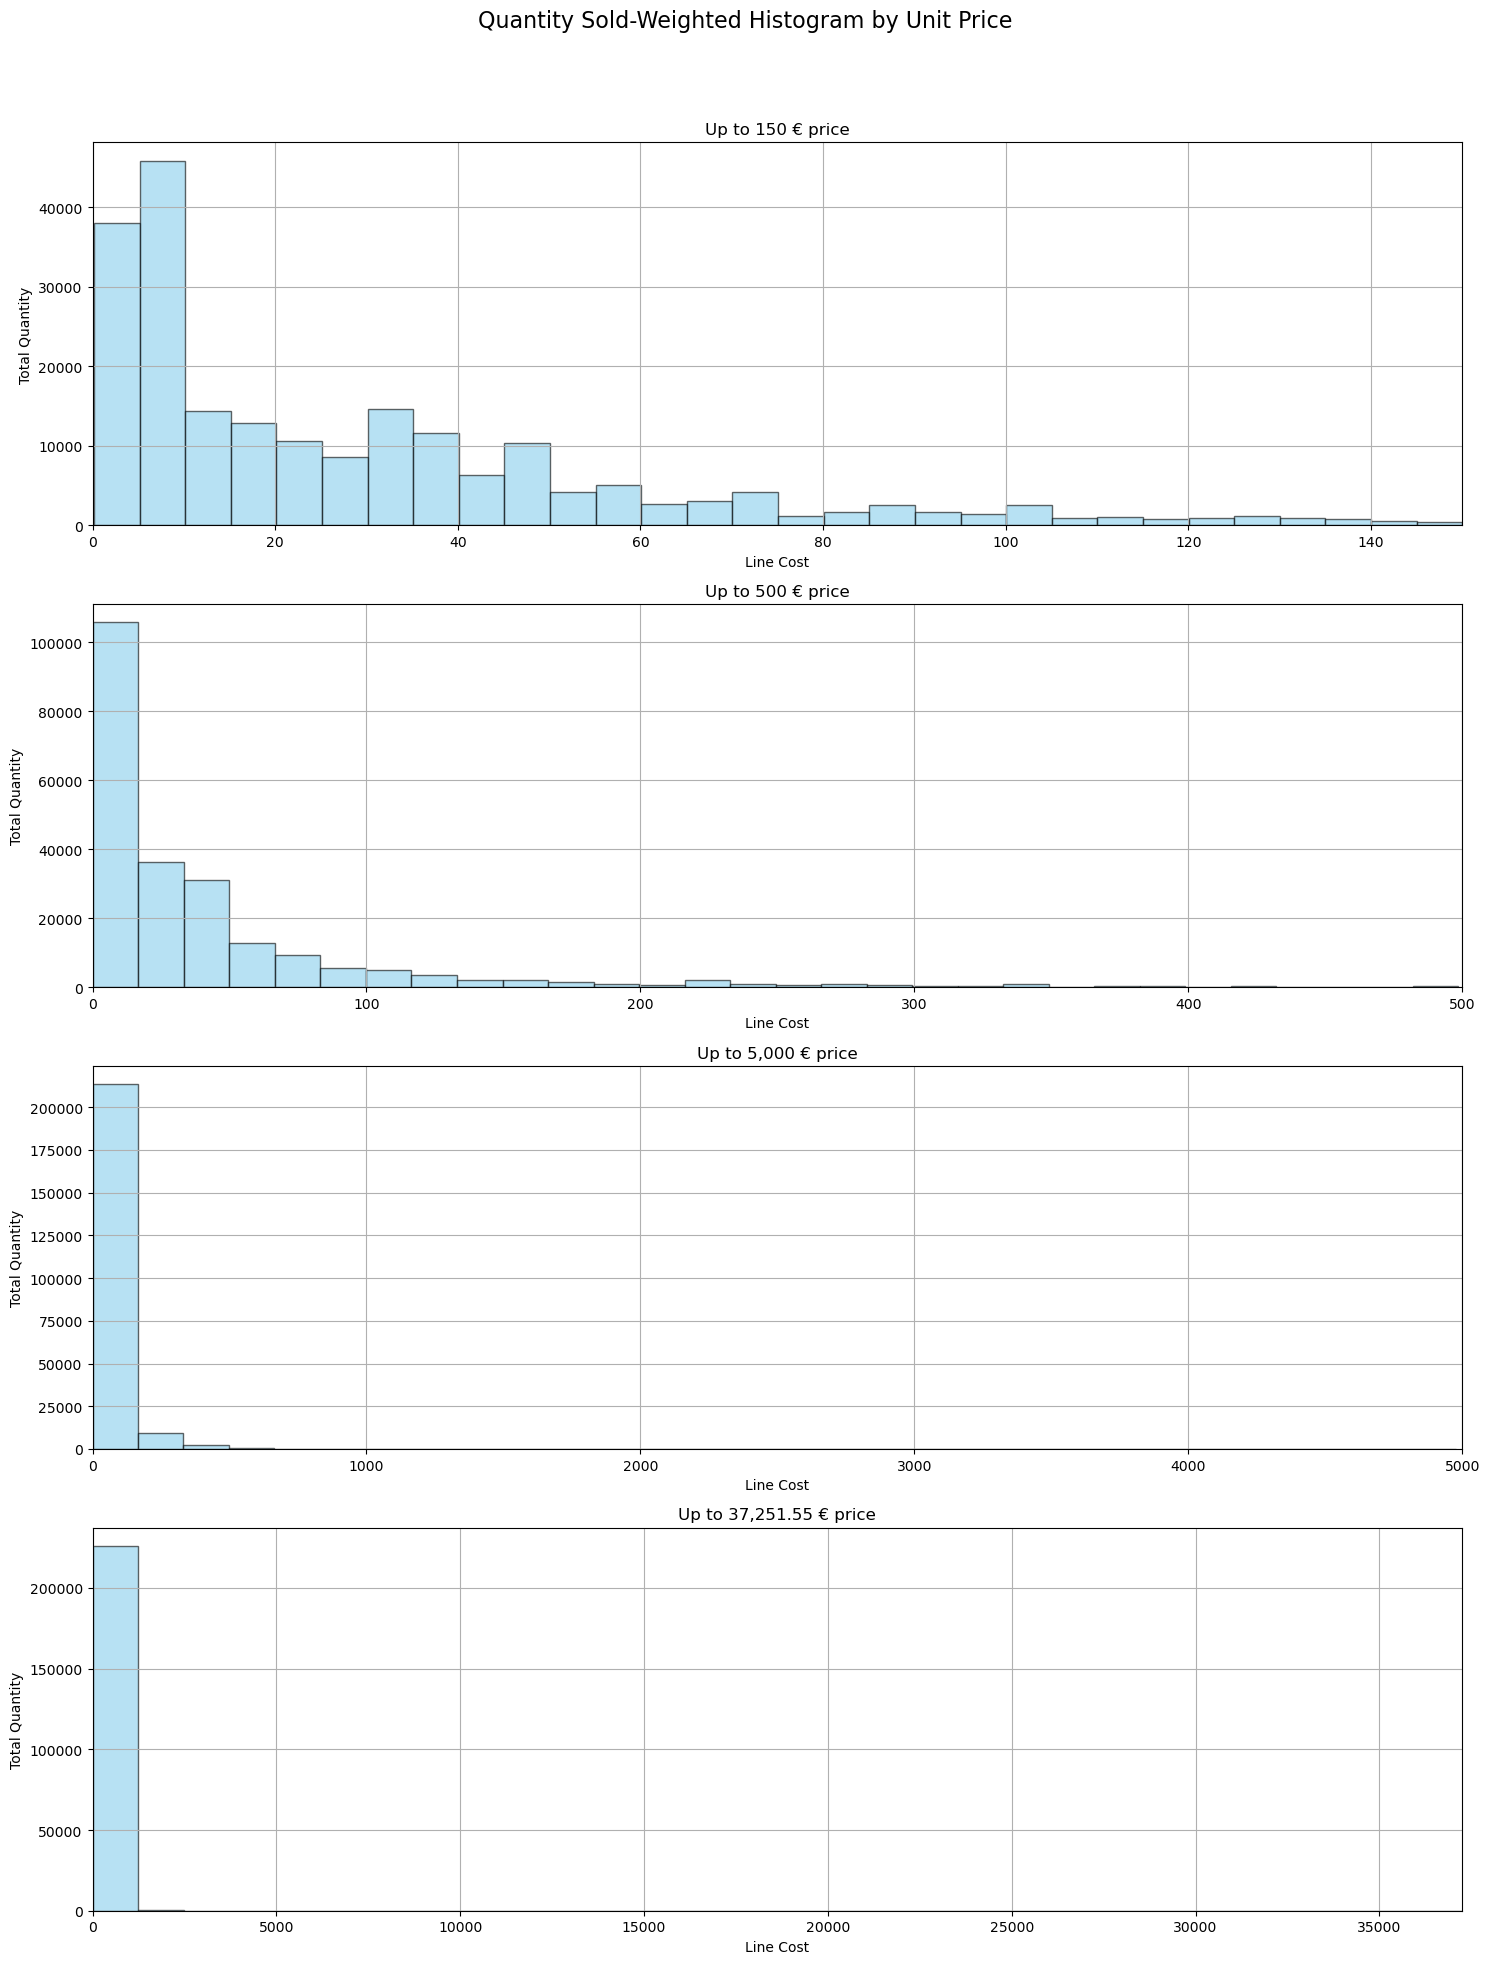

In [81]:
sale_vol = df.merge(cost.drop_duplicates('item_id', keep='first'), how='left')
sale_vol = sale_vol[sale_vol.unit_cost > 0] # keep only items that have a price
#sale_vol = sale_vol[sale_vol.unit_cost <= 200] # keep only items that have a low price
sale_vol['line_cost'] = sale_vol.quantity * sale_vol.unit_cost

max_price = sale_vol['unit_cost'].max()

# Define x-limits for each subplot
x_limits = [150, 500, 5_000, max_price]

fig, axes = plt.subplots(4, 1, figsize=(15, 20))

for ax, xlim in zip(axes, x_limits):
    ax.hist(
        sale_vol['unit_cost'][sale_vol.unit_cost <= xlim], 
        weights=sale_vol['quantity'][sale_vol.unit_cost <= xlim],
        bins=30, 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.6
    )
    ax.set_xlim(0, xlim)
    ax.set_title(f'Up to {xlim:,} € price')
    ax.set_xlabel('Line Cost')
    ax.set_ylabel('Total Quantity')
    ax.grid(True)

plt.suptitle('Quantity Sold-Weighted Histogram by Unit Price', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Make full index

In [5]:
# create a full article-date set
items = df.item_id.unique()
df['month'] = df.so_date.dt.to_period('M')
months = pd.period_range(df.month.min(), df.month.max(), freq='M')
full_index = pd.MultiIndex.from_product([items, months], names=['item_id', 'month'])

#group by month
monthly_sales = (df.groupby(['item_id', 'month'])
                 .agg(quantity=("quantity", "sum"))
                 .reset_index())

sales = (monthly_sales.set_index(['item_id', 'month'])
         .reindex(full_index, fill_value=0)
         .reset_index())

print(len(sales))
sales.head()

80304


,item_id,month,quantity
0,00517,2022-12,0
1,00517,2023-01,0
2,00517,2023-02,2
3,00517,2023-03,0
4,00517,2023-04,0


Calcualte the coefficient of variation
- this is the measure of how much an item is volatile

In [6]:
stats = (sales.groupby('item_id')
         .agg(mean=("quantity", "mean"), 
                    std=("quantity", "std"))
         .reset_index())
stats['cv'] = stats['std'] / stats['mean']
stats = stats.drop(columns=['std'])
stats

,item_id,mean,cv
0,00301,1.928571,1.639266
1,00301C,0.321429,3.696041
2,00301SW,0.071429,3.671714
3,00302,0.214286,3.885183
4,00302C,0.714286,2.847741
...,...,...,...
2863,ZHS24.341-1400,0.714286,3.671714
2864,ZHS24.341-1480,2.535714,2.012262
2865,ZHS24.42-0300,4.642857,1.657217
2866,ZHS24.42-1150,4.214286,1.605938


Calculate the frequency
- how many months with sales

In [7]:
n_months = sales.month.nunique()
freq_ratio = (
    sales.groupby('item_id')['quantity']
    .apply(lambda x: (x>0).sum())
    /n_months
)
freq_ratio = freq_ratio.to_frame().reset_index()
freq_ratio = freq_ratio.rename(columns={'quantity':'freq_ratio'})
stats = pd.merge(stats, freq_ratio, how='left', on='item_id')
len(stats)

2868

Merge data

In [9]:
stats = stats.merge(cost.drop_duplicates('item_id', keep='first'), how='left')
msno.matrix(stats)

NameError: name 'cost' is not defined

In [198]:
len(stats)

2868

<Axes: >

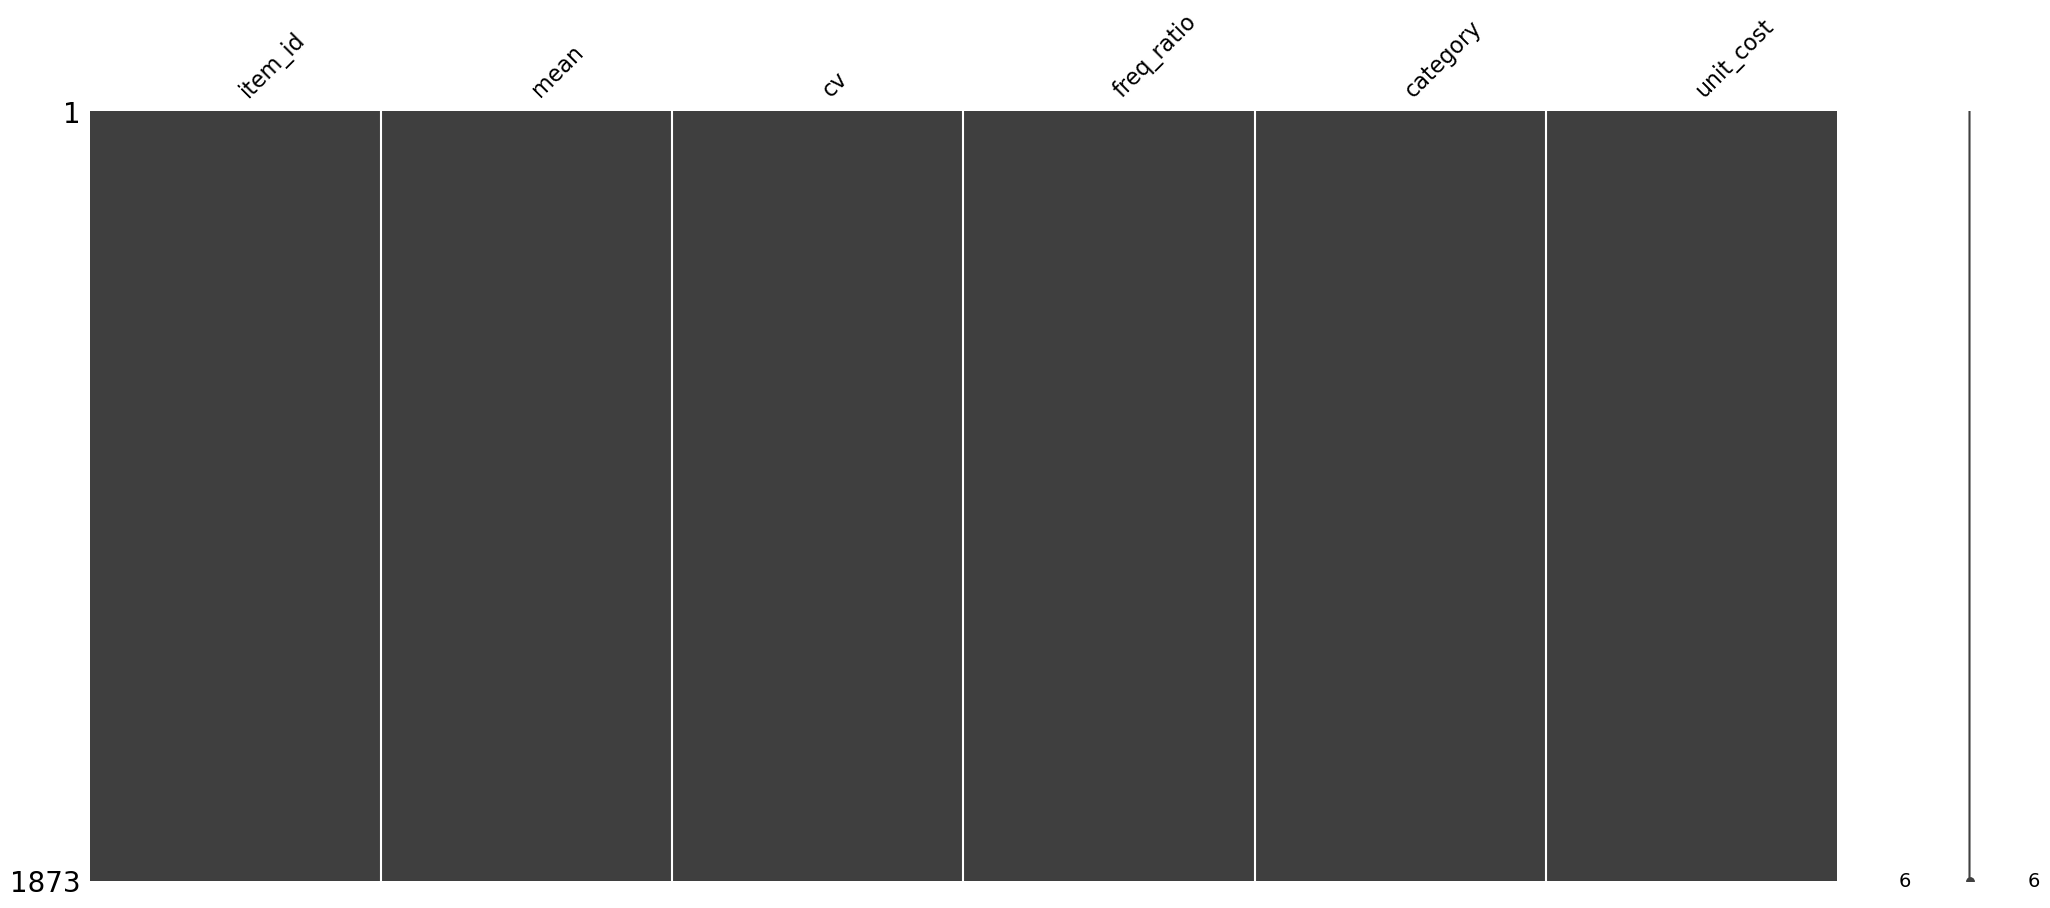

In [199]:
null_prices = stats[stats['unit_cost'].isna()]
null_prices.to_csv('../data/null_prices.csv')
# 56 articles, excluding components, are missing prices and will be dropped from the dataframe

stats = stats.drop(stats[stats.unit_cost.isna()].index)
msno.matrix(stats)

bring in the average lt

In [200]:
lt = df[['item_id', 'lt']].groupby('item_id').mean().reset_index()
#lt['lt'] = lt['lt'].round(0).astype(int)
stats = stats.merge(lt, how='left')

In [184]:
stats

,item_id,mean,cv,freq_ratio,category,unit_cost,lt
0,00301,1.928571,1.639266,0.392857,Bozzelli (20),15.04,27
1,00301C,0.321429,3.696041,0.071429,Bozzelli (20),22.56,25
2,00301SW,0.071429,3.671714,0.071429,Bozzelli (20),18.88,43
3,00302,0.214286,3.885183,0.071429,Bozzelli (20),15.64,48
4,00302C,0.714286,2.847741,0.142857,Bozzelli (20),26.49,29
...,...,...,...,...,...,...,...
1868,ZHS24.341-1400,0.714286,3.671714,0.071429,Rotaie (100),37.40,25
1869,ZHS24.341-1480,2.535714,2.012262,0.250000,Rotaie (100),37.41,46
1870,ZHS24.42-0300,4.642857,1.657217,0.392857,Rotaie (100),47.71,47
1871,ZHS24.42-1150,4.214286,1.605938,0.392857,Rotaie (100),75.99,39


In [201]:
stats = stats[['item_id', 'category', 'mean', 'cv', 'freq_ratio', 'unit_cost', 'lt']]
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873 entries, 0 to 1872
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item_id     1873 non-null   object 
 1   category    1873 non-null   object 
 2   mean        1873 non-null   float64
 3   cv          1873 non-null   float64
 4   freq_ratio  1873 non-null   float64
 5   unit_cost   1873 non-null   float64
 6   lt          1873 non-null   float64
dtypes: float64(5), object(2)
memory usage: 102.6+ KB


Scale the variables and direct them
- cv remains (low = better)
- freq_ratio is inverted (high = better in the original)
- unit_cost remains (low = better)
- mlor is inverted (high = better in the original)

In [203]:
scaler = StandardScaler()
stats['mean_is'] = scaler.fit_transform(-stats[['mean']])

scaler = StandardScaler()
stats['cv_s'] = scaler.fit_transform(stats[['cv']])

scaler = StandardScaler()
stats['freq_ratio_is'] = scaler.fit_transform(-stats[['freq_ratio']])

scaler = StandardScaler()
stats['unit_cost_s'] = scaler.fit_transform(stats[['unit_cost']])

scaler = StandardScaler()
stats['lt_is'] = scaler.fit_transform(-stats[['lt']])

In [204]:
stats.head()

,item_id,category,mean,cv,freq_ratio,unit_cost,lt,mean_is,cv_s,freq_ratio_is,unit_cost_s,lt_is
0,00301,Bozzelli (20),1.928571,1.639266,0.392857,15.04,27.117647,0.112725,-1.003934,-0.616921,-0.245831,0.527462
1,00301C,Bozzelli (20),0.321429,3.696041,0.071429,22.56,25.200000,0.188288,0.310643,0.695145,-0.240275,0.585185
2,00301SW,Bozzelli (20),0.071429,3.671714,0.071429,18.88,43.000000,0.200042,0.295094,0.695145,-0.242994,0.049384
3,00302,Bozzelli (20),0.214286,3.885183,0.071429,15.64,48.000000,0.193325,0.431532,0.695145,-0.245388,-0.101122
4,00302C,Bozzelli (20),0.714286,2.847741,0.142857,26.49,29.000000,0.169817,-0.231543,0.403575,-0.237372,0.470801


Create a simple Volatility Score
- cv + inverted freq (measures both variability and frequency)

In [205]:
stats['volatility'] = stats.cv_s + stats.freq_ratio_is
stats['importance'] = stats.cv_s + stats.mean_is

Cluster the top and bottom 20 percentiles of volatility

In [206]:
def label_volatility(score):
    if score <= stats.volatility.quantile(0.2):
        return 'stable'
    elif score >= stats.volatility.quantile(0.8):
        return 'unstable'
    else:
        return 'middle'
    
def label_importance(score):
    if score <= stats.importance.quantile(0.2):
        return 'important'
    elif score >= stats.importance.quantile(0.8):
        return 'unimportant'
    else:
        return 'middle'
    
stats['vol_label'] = stats.volatility.apply(label_volatility)
stats['imp_label'] = stats.importance.apply(label_importance)

Plot Volatility

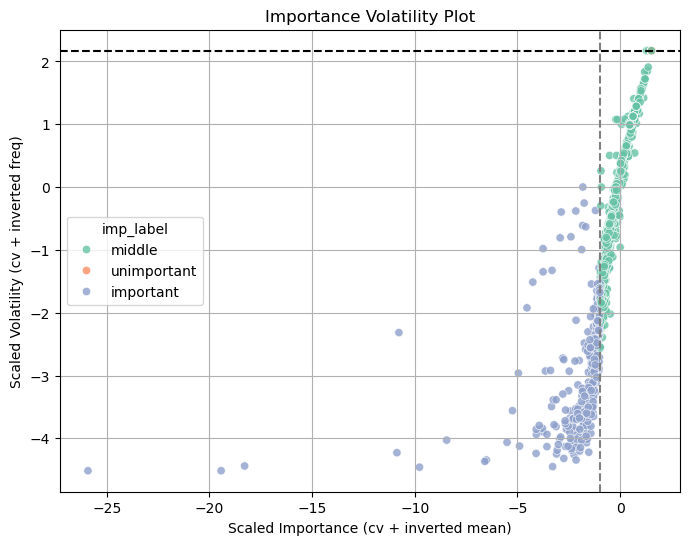

In [222]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=stats,
    x='importance',
    y='volatility',
    hue='imp_label',
    palette='Set2',
    alpha=0.8
)

# add treshold lines
cv_threshold = stats['importance'].quantile(0.2)
freq_threshold = stats['volatility'].quantile(0.8)
plt.axvline(cv_threshold, color='gray', linestyle='--', label='CV 20th percentile')
plt.axhline(freq_threshold, color='black', linestyle='--', label='Freq 80th percentile')

plt.xlabel('Scaled Importance (cv + inverted mean)')
plt.ylabel('Scaled Volatility (cv + inverted freq)')
plt.title('Importance Volatility Plot')
plt.grid(True)

plt.show()

Cluster features

In [218]:
features = ['importance', 'volatility', 'unit_cost_s']
#features = ['importance', 'volatility']

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(stats[features])

# add lables
stats.loc[stats.index, 'cluster'] = clusters

# summarize
cluster_summary = stats.loc[stats.index].groupby('cluster')[features].mean()
display(cluster_summary)
print(stats.cluster.value_counts())

,importance,volatility,unit_cost_s
cluster,,,
0.0,1.243311,1.839174,0.175214
1.0,-1.803265,-2.860051,-0.165473
2.0,-0.353769,-0.406522,-0.103623


cluster
0.0    787
2.0    676
1.0    410
Name: count, dtype: int64


Reduce dimensionality to plot

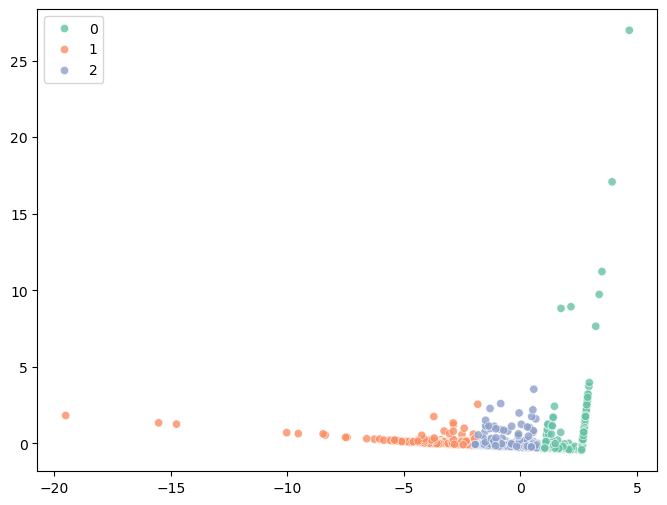

In [219]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(stats[features])

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    palette='Set2',
    hue=clusters,
    alpha=0.8
)


plt.show()

Elbow method to determine the number of clusters

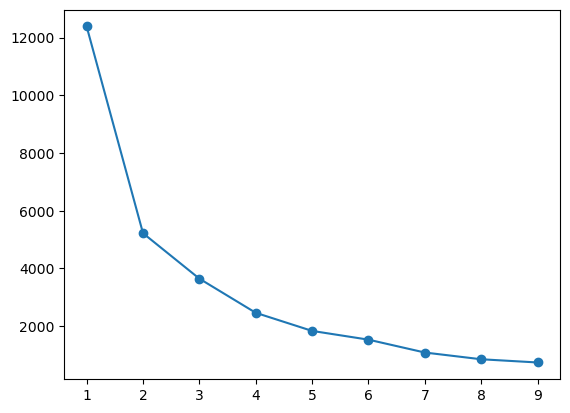

In [220]:
inertia = []
k_range = range(1, 10)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_pca)
    inertia.append(model.inertia_)

plt.plot(k_range, inertia, marker='o')

plt.show()

Pairplots

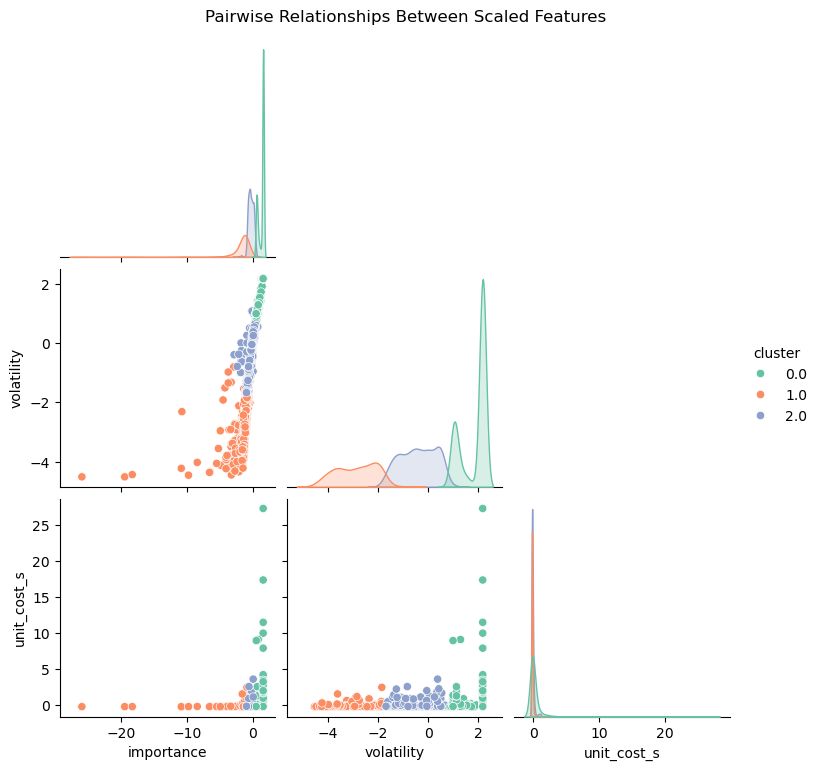

In [221]:
sns.pairplot(
    data=stats,
    vars=features,
    hue='cluster',  # or 'volatility_label'
    palette='Set2',
    corner=True,
    diag_kind='kde'
)

plt.suptitle("Pairwise Relationships Between Scaled Features", y=1.02)
plt.show()

In [231]:
stats[stats.cluster == 1].groupby(['category']).agg(total=('category', 'size'))
stats.to_csv('../data/stats.csv')

,mean,freq_ratio,unit_cost,lt
category,,,,
Accessori (10),3.585548,0.285714,103.891163,45.323970
Art. Promozionali (15),13.932773,0.132353,16.401176,29.120215
Bozzelli (20),1.622493,0.215002,208.332350,46.201015
Carrelli a sfere (30),0.753115,0.162583,435.094942,52.449711
Carrelli su rotaia T (40),3.683741,0.238252,254.866711,55.165205
Full Batten (50),4.611529,0.256475,146.583684,43.921538
Pulegge (90),1.880309,0.191602,83.601757,28.985586
Rinvii (95),2.523987,0.279495,182.605224,50.698783
Rotaie (100),4.809825,0.171867,206.178845,43.326592


cluster
0.0    786
2.0    673
1.0    414
Name: count, dtype: int64


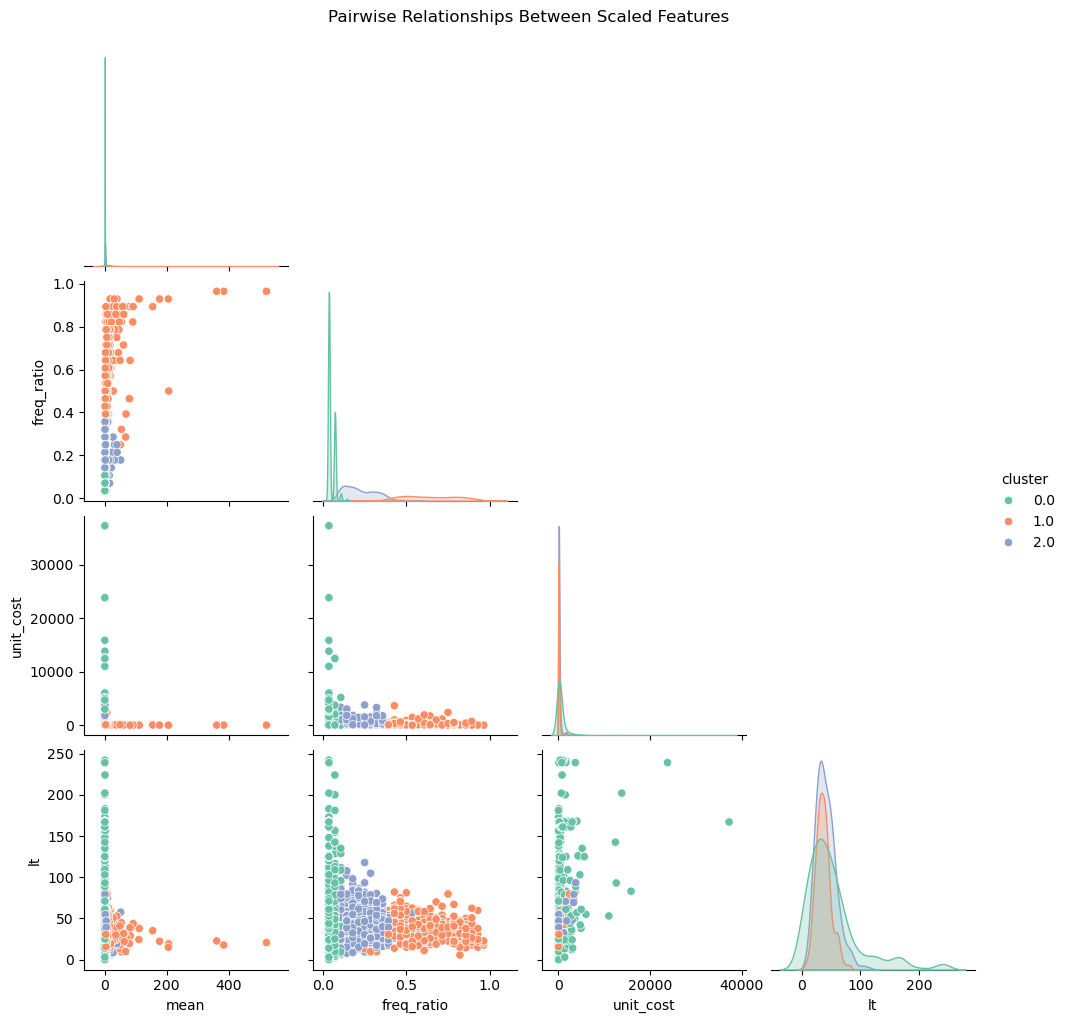

In [217]:
features_basis = ['mean', 'freq_ratio', 'unit_cost', 'lt']

# summarize
cluster_summary = stats.loc[stats.index].groupby(['category'])[features_basis].mean()
display(cluster_summary)
print(stats.cluster.value_counts())


sns.pairplot(
    data=stats,
    vars=features_basis,
    hue='cluster',  # or 'volatility_label'
    palette='Set2',
    corner=True,
    diag_kind='kde'
)

plt.suptitle("Pairwise Relationships Between Scaled Features", y=1.02)
plt.show()